<a href="https://colab.research.google.com/github/oguzhanatas/ml_TdTk/blob/main/diskBoundary_v001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm.keras import TqdmCallback
tf.__version__

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path_of_folder = '/content/drive/My Drive/Colab Notebooks/'
data = path_of_folder + 'colab_data/21_RC_SigmaPi005Galpy_new.csv'

path_pop_boundry=path_of_folder +'colab_data/desicion_boundary_rc.txt'

Mounted at /content/drive


alphafe    0
feh        0
snr_a      0
snr_g      0
U          0
V          0
W          0
dtype: int64
42047
    alphafe       feh       snr_a   snr_g          U          V          W  \
0  0.032994  0.060205  343.740997 -9999.0 -15.118205 -27.462988  23.921085   
1  0.054181 -0.299762  205.179001 -9999.0 -44.877055   1.330864  -0.352611   
2  0.036741  0.029631  171.550003 -9999.0  -8.422155 -28.833191 -16.602430   
3  0.044084 -0.314392  265.123993 -9999.0 -50.255022  -2.014292   8.594566   
4  0.010752 -0.003472  714.874023 -9999.0 -32.813834  16.331829  14.781312   

   population  
0           0  
1           0  
2           0  
3           0  
4           0  
alphafe       0
feh           0
snr_a         0
snr_g         0
U             0
V             0
W             0
population    0
dtype: int64
tot:42047, pop1: 16926, pop0: 25121, popNaN: 0
42047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


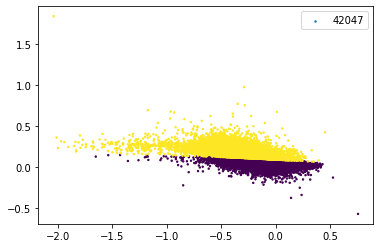

In [17]:
#column_names=['feh_all','alphafe','snr_a','snr_ort_galah','U','V','W','parallax']
rc = pd.read_csv(data, sep=",",low_memory=False)
#for i in rc.columns:
#  print(i)

dataframe=pd.DataFrame({'alphafe':rc['alphafe'],'feh':rc['feh_all'],'snr_a':rc['snr_a'],'snr_g':rc['snr_ort_galah'],'U':rc['U'],'V':rc['V'],'W':rc['W']},index=None).dropna()
print(dataframe.isna().sum())
print(len(dataframe))
#print(dataframe.head())


#dataframe=rc.copy()
pop_boundry=np.loadtxt(path_pop_boundry,delimiter=',')
#pop ayrimi cizgisi
pop_x=np.array(pop_boundry[:,0])
pop_y=np.array(pop_boundry[:,1])
coefs = np.polyfit(pop_x, pop_y, 2)
pop_sel_func = np.poly1d(coefs)
pop_sel_value= pop_sel_func(dataframe['feh'])
thin_mask = (dataframe['alphafe'] <= pop_sel_value)
thick_mask = (dataframe['alphafe'] > pop_sel_value)


thin_data=dataframe[thin_mask]
thin_data['population']=[0]*len(thin_data)
thick_data=dataframe[thick_mask]
thick_data['population']=[1]*len(thick_data)

#dataset = thin_data2.append(thick_data2,ignore_index=True, sort=False)
dataset=pd.concat([thin_data,thick_data],ignore_index=True, axis=0,)
print(dataset.head())
print(dataset.isna().sum())


plt.scatter(dataset['feh'],dataset['alphafe'],c=dataset['population'],s=2,label='{}'.format(len(dataset['population'][(dataset['population']==0)|(dataset['population']==1)])))
plt.legend()
print('tot:{}, pop1: {}, pop0: {}, popNaN: {}'.format(len(dataset['population']),len(dataset['population'][dataset['population']==1]),len(dataset['population'][dataset['population']==0]),dataset['population'].isnull().sum()))
print(len(dataset['population'][dataset['population']==1])+len(dataset['population'][dataset['population']==0])+dataset['population'].isnull().sum())

In [18]:
print(dataset.shape)
print(dataset.columns)

(42047, 8)
Index(['alphafe', 'feh', 'snr_a', 'snr_g', 'U', 'V', 'W', 'population'], dtype='object')


In [19]:

population=dataset.pop('population')
print(population.shape,dataset.shape)

(42047,) (42047, 7)


In [20]:
numeric_features_names=['alphafe', 'feh', 'snr_a', 'snr_g', 'U', 'V', 'W']
numeric_features=dataset[numeric_features_names]
numeric_features.head()

,alphafe,feh,snr_a,snr_g,U,V,W
0,0.032994,0.060205,343.740997,-9999.0,-15.118205,-27.462988,23.921085
1,0.054181,-0.299762,205.179001,-9999.0,-44.877055,1.330864,-0.352611
2,0.036741,0.029631,171.550003,-9999.0,-8.422155,-28.833191,-16.602430
3,0.044084,-0.314392,265.123993,-9999.0,-50.255022,-2.014292,8.594566
4,0.010752,-0.003472,714.874023,-9999.0,-32.813834,16.331829,14.781312


In [21]:
inputs=keras.Input(shape=(7,),name='population')
x=layers.Dense(64,activation='relu',name='dense_1')(inputs)
x=layers.Dense(64,activation='relu',name='dense_2')(x)
outputs=layers.Dense(10,activation='softmax',name='predictions')(x)

In [22]:
model=keras.Model(inputs=inputs,outputs=outputs)

In [23]:
(x_train,y_train),(x_test,y_test)=(numeric_features,population),(numeric_features,population)

In [24]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [25]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Minimize loss:
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Monitor metrics:
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [26]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # Validation of loss and metrics
    # at the end of each epoch:
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
501/501 [==============================] - 2s 3ms/step - loss: 57.3635 - sparse_categorical_accuracy: 0.6733 - val_loss: 284.8877 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/2
501/501 [==============================] - 1s 2ms/step - loss: 29.4180 - sparse_categorical_accuracy: 0.7074 - val_loss: 227.2764 - val_sparse_categorical_accuracy: 0.0012


In [27]:
history.history

{'loss': [57.36349868774414, 29.417984008789062],
 'sparse_categorical_accuracy': [0.6733235716819763, 0.7073673009872437],
 'val_loss': [284.8876647949219, 227.27638244628906],
 'val_sparse_categorical_accuracy': [0.0, 0.0012000000569969416]}

In [28]:
print("Evaluate model on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate model on test data
329/329 [==============================] - 1s 3ms/step - loss: 79.4640 - sparse_categorical_accuracy: 0.6015
test loss, test acc: [79.4639892578125, 0.6014935374259949]


In [31]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(x_test)
print("prediction shape:", prediction.shape)

Generate a prediction
1314/1314 [==============================] - 2s 1ms/step
prediction shape: (42047, 10)


In [38]:
print("Prediction: {}".format(len(tf.argmax(prediction, axis=1))))
print("    Labels: {}".format(len(population)))

Prediction: 42047
    Labels: 42047


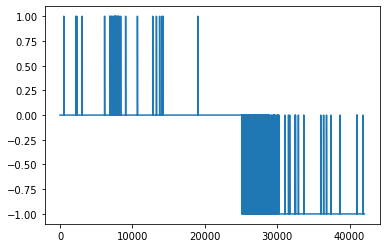

In [41]:
plt.plot(tf.argmax(prediction, axis=1)-population)